In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Dataset

#### Create derivative metrics

In [2]:
df = pd.read_csv('results.csv')

df['Throughput'] = (df['Out tokens'] * df['Batch Size']) / df['Latency']
df['TBT'] = (df['Latency']*1000 - df['TTFT']) / df['Out tokens']
df['Energy/Token'] = df['Energy']/(df['In tokens'] + df['Out tokens'])
df['Active Energy/Token'] = df['Energy (Active)']/(df['In tokens'] + df['Out tokens'])
df['TP per Watt (Active)'] = df['Throughput'] / df['Power Avg (Active)']
df['TP per Watt'] = df['Throughput'] / df['Power Avg']

df

FileNotFoundError: [Errno 2] No such file or directory: 'results.csv'

In [ ]:
print(df['Model Name'].unique())

['meta-llama/Llama-2-7b-hf' 'meta-llama/Meta-Llama-3-8B'
 'mistralai/Mistral-7B-v0.1' 'Qwen/Qwen2-7B'
 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B']


In [ ]:
print(df['FrameWork'].unique())

['vLLM' 'Accelerate']


In [ ]:
print(df['Hardware type'].unique())

['NVIDIA A100-PCIE-40GB' 'NVIDIA A100-SXM4-40GB']


In [ ]:
model = 'meta-llama/Meta-Llama-3-8B'
hardware = 'NVIDIA A100-SXM4-40GB'
precision = 'bfloat16'
batch = 8
framework = 'vLLM'

model_df = model_df = df[
    (df['Model Name'] == model) &
    (df['Hardware type'] == hardware) &
    (df['FrameWork'] == framework)]

# Latencies

#### Latency - sequence lenght relation

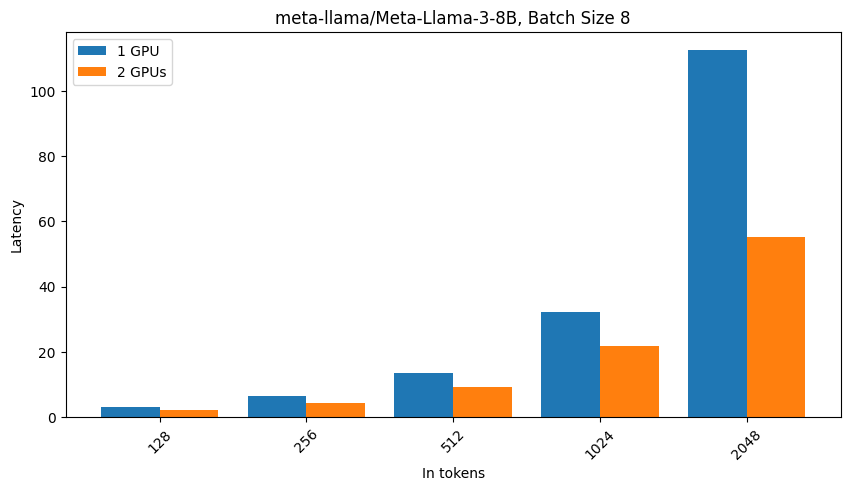

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
    
batch_df = model_df[model_df['Batch Size'] == batch]

# Get unique 'In tokens' values
in_tokens = sorted(batch_df['In tokens'].unique())

# Extract latency values for 1 and 2 GPUs
lat_1gpu = []
lat_2gpu = []

for tokens in in_tokens:
    lat_1gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 1)]['Latency'].mean())
    lat_2gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 2)]['Latency'].mean())

# Bar width
width = 0.4  
x = np.arange(len(in_tokens))

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, lat_1gpu, width, label="1 GPU")
plt.bar(x + width/2, lat_2gpu, width, label="2 GPUs")

plt.xlabel('In tokens')
plt.ylabel('Latency')
plt.title(f"{model}, Batch Size {batch}")
plt.xticks(x, in_tokens, rotation=45)
plt.legend()
plt.show()


#### Latency - Sequence Size across multiple batch sizes

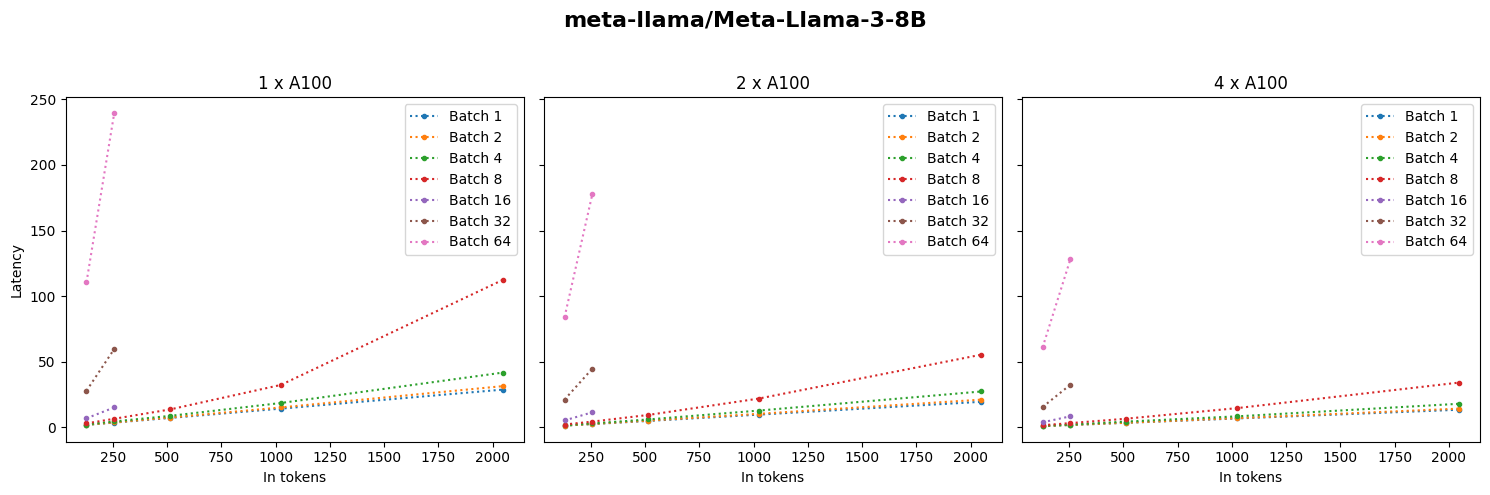

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_values = model_df['Count'].unique()
num_plots = len(n_values)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)  # One row, multiple columns

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable if only one plot

for ax, n in zip(axes, n_values):
    for batch in model_df['Batch Size'].unique():
        sub_df = model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == n)]
        sub_df = sub_df.sort_values(by='In tokens')  # Ensure sorting
        ax.plot(sub_df['In tokens'], sub_df['Latency'], linestyle=':', marker='.', label=f"Batch {batch}")

    ax.set_title(f"{n} x A100")
    ax.set_xlabel('In tokens')
    ax.legend()

axes[0].set_ylabel('Latency')  # Set y-label only on the first plot

fig.suptitle(model, fontsize=16, fontweight='bold') 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



#### Latency-Batch Size heatmap

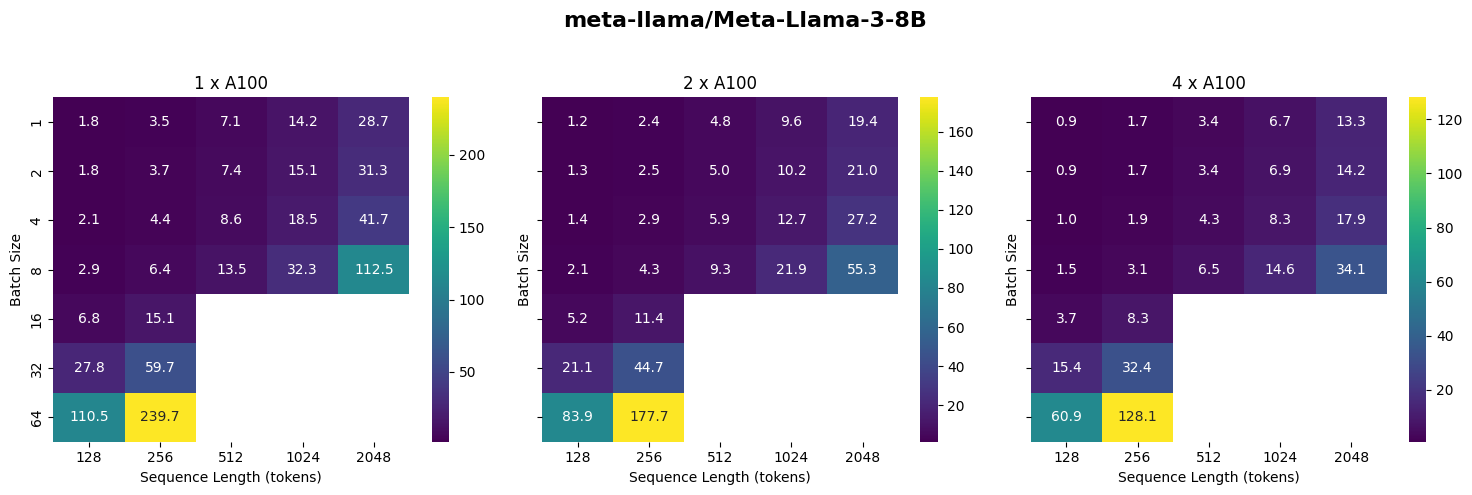

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

n_values = model_df['Count'].unique()
num_plots = len(n_values)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable if only one plot

for ax, n in zip(axes, n_values):
    sub_df = model_df[(model_df['Count'] == n)]

    pivot_table = sub_df.pivot(index='Batch Size', columns='In tokens', values='Latency')
    
    sns.heatmap(pivot_table, ax=ax, cmap='viridis', annot=True, fmt=".1f", cbar=True)
    
    ax.set_title(f"{n} x A100")
    ax.set_xlabel('Sequence Length (tokens)')
    ax.set_ylabel('Batch Size')
    
fig.suptitle(model, fontsize=16, fontweight='bold') 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# TTFT

#### TTFT - sequence lenght relation

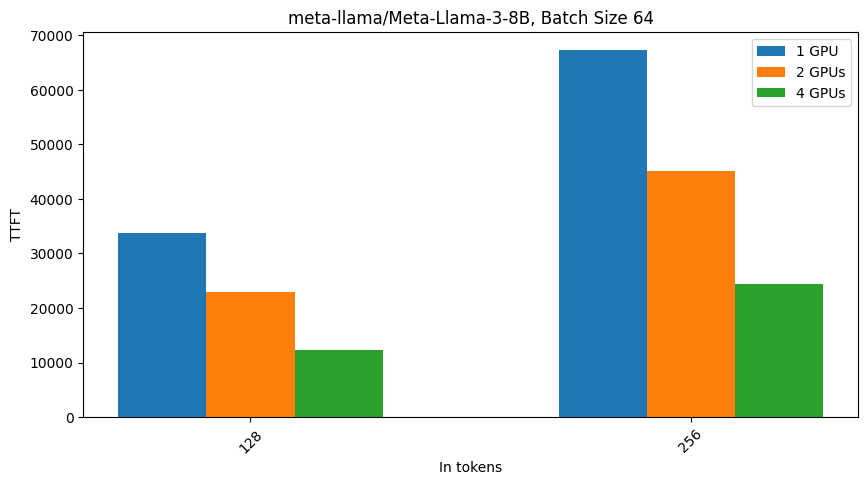

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
    
batch_df = model_df[model_df['Batch Size'] == batch]

# Get unique 'In tokens' values
in_tokens = sorted(batch_df['In tokens'].unique())

# Extract latency values for 1 and 2 GPUs
lat_1gpu = []
lat_2gpu = []
lat_4gpu = []

for tokens in in_tokens:
    lat_1gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 1)]['TTFT'].mean())
    lat_2gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 2)]['TTFT'].mean())
    lat_4gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 4)]['TTFT'].mean())

# Bar width
width = 0.2  
x = np.arange(len(in_tokens))

plt.figure(figsize=(10, 5))
plt.bar(x - width, lat_1gpu, width, label="1 GPU")
plt.bar(x, lat_2gpu, width, label="2 GPUs")
plt.bar(x + width, lat_4gpu, width, label="4 GPUs")

plt.xlabel('In tokens')
plt.ylabel('TTFT')
plt.title(f"{model}, Batch Size {batch}")
plt.xticks(x, in_tokens, rotation=45)
plt.legend()
plt.show()

#### TTFT - Sequence Size across multiple batch sizes

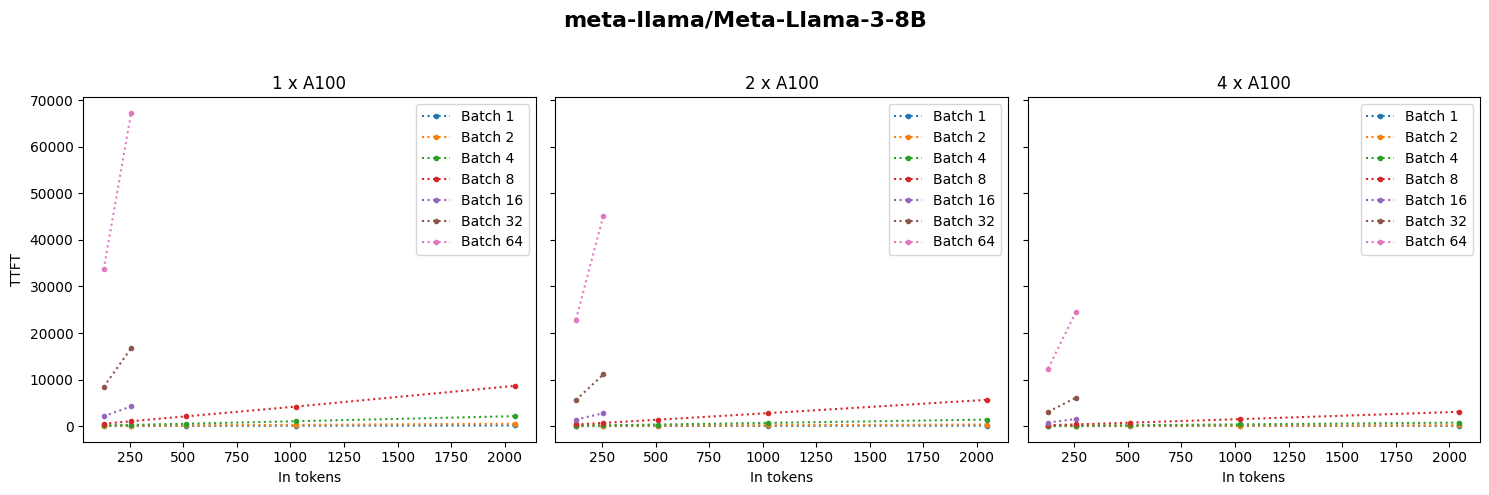

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_values = model_df['Count'].unique()
num_plots = len(n_values)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)  # One row, multiple columns

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable if only one plot

for ax, n in zip(axes, n_values):
    for batch in model_df['Batch Size'].unique():
        sub_df = model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == n)]
        sub_df = sub_df.sort_values(by='In tokens')  # Ensure sorting
        ax.plot(sub_df['In tokens'], sub_df['TTFT'], linestyle=':', marker='.', label=f"Batch {batch}")

    ax.set_title(f"{n} x A100")
    ax.set_xlabel('In tokens')
    ax.legend()

axes[0].set_ylabel('TTFT')  # Set y-label only on the first plot

fig.suptitle(model, fontsize=16, fontweight='bold') 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



#### TTFT - Batch Size heatmap

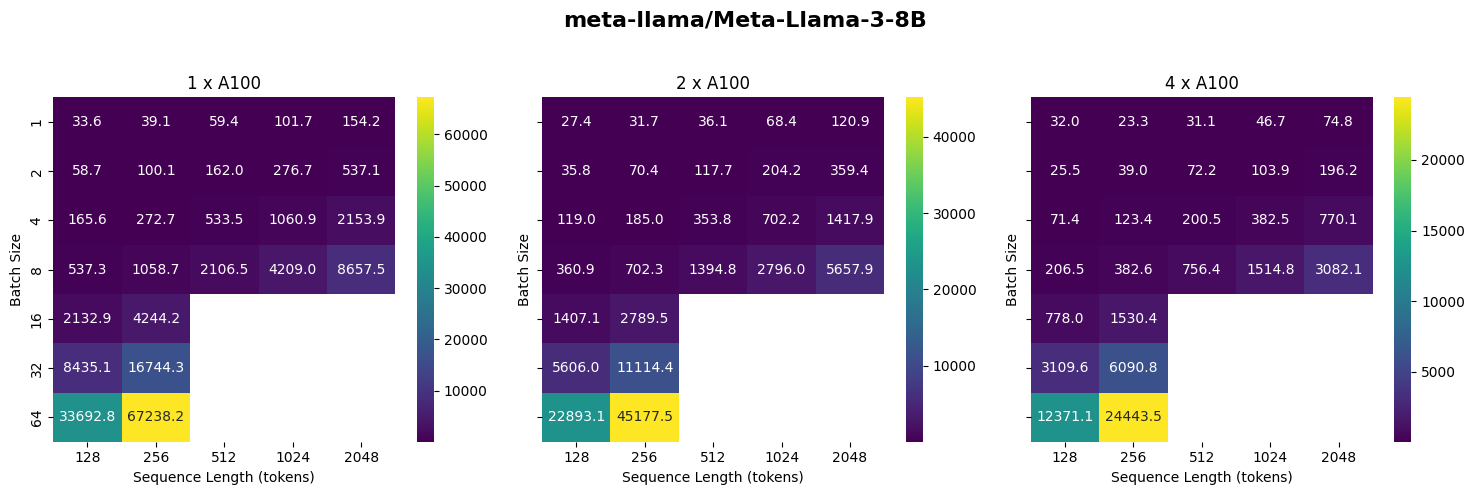

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

n_values = model_df['Count'].unique()
num_plots = len(n_values)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable if only one plot

for ax, n in zip(axes, n_values):
    sub_df = model_df[(model_df['Count'] == n)]

    pivot_table = sub_df.pivot(index='Batch Size', columns='In tokens', values='TTFT')
    
    sns.heatmap(pivot_table, ax=ax, cmap='viridis', annot=True, fmt=".1f", cbar=True)
    
    ax.set_title(f"{n} x A100")
    ax.set_xlabel('Sequence Length (tokens)')
    ax.set_ylabel('Batch Size')
    
fig.suptitle(model, fontsize=16, fontweight='bold') 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Throughput

#### Throughput - Sequence Lenght relation

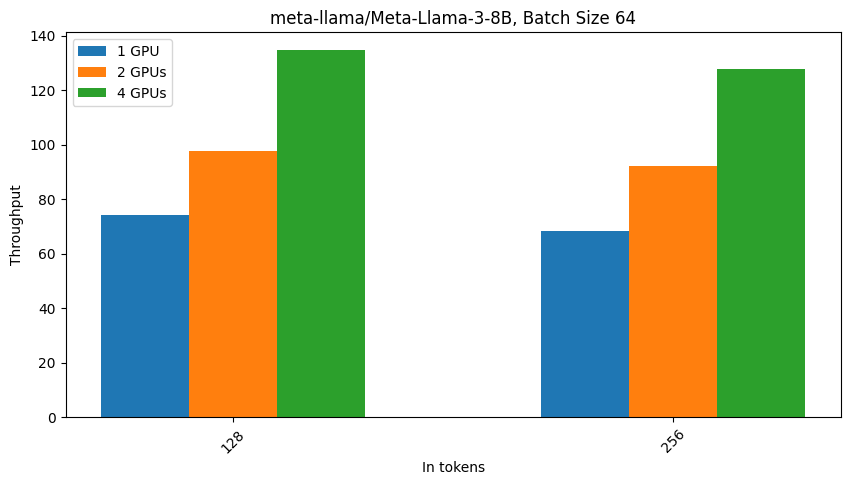

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
    
batch_df = model_df[model_df['Batch Size'] == batch]

# Get unique 'In tokens' values
in_tokens = sorted(batch_df['In tokens'].unique())

# Extract latency values for 1 and 2 GPUs
lat_1gpu = []
lat_2gpu = []
lat_4gpu = []

for tokens in in_tokens:
    lat_1gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 1)]['Throughput'].mean())
    lat_2gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 2)]['Throughput'].mean())
    lat_4gpu.append(batch_df[(batch_df['In tokens'] == tokens) & (batch_df['Count'] == 4)]['Throughput'].mean())

# Bar width
width = 0.2  
x = np.arange(len(in_tokens))

plt.figure(figsize=(10, 5))
plt.bar(x - width, lat_1gpu, width, label="1 GPU")
plt.bar(x, lat_2gpu, width, label="2 GPUs")
plt.bar(x + width, lat_4gpu, width, label="4 GPUs")

plt.xlabel('In tokens')
plt.ylabel('Throughput')
plt.title(f"{model}, Batch Size {batch}")
plt.xticks(x, in_tokens, rotation=45)
plt.legend()
plt.show()


#### Throughput across batch sizes and sequence lenghts

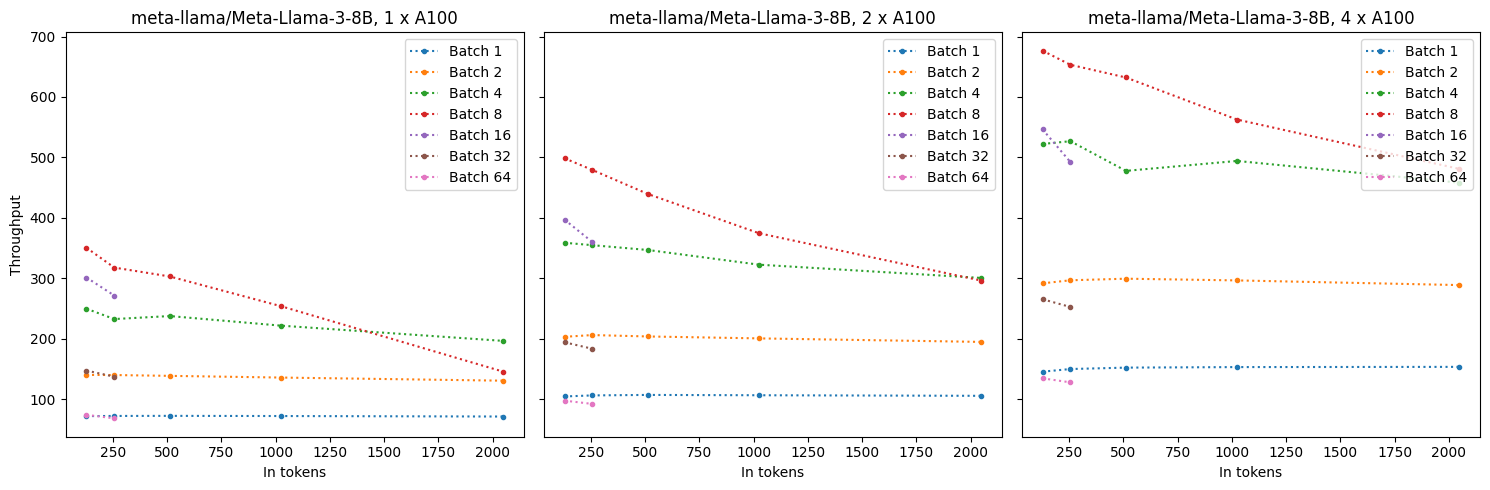

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_values = model_df['Count'].unique()
num_plots = len(n_values)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)  # One row, multiple columns

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable if only one plot

for ax, n in zip(axes, n_values):
    for batch in model_df['Batch Size'].unique():
        sub_df = model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == n)]
        sub_df = sub_df.sort_values(by='In tokens')  # Ensure sorting

        ax.plot(sub_df['In tokens'], sub_df['Throughput'], linestyle=':', marker='.', label=f"Batch {batch}")

    ax.set_title(f"{model}, {n} x A100")
    ax.set_xlabel('In tokens')
    ax.legend()

axes[0].set_ylabel('Throughput')  # Set y-label only on the first plot

plt.tight_layout()
plt.show()


#### Throughput Heatmap

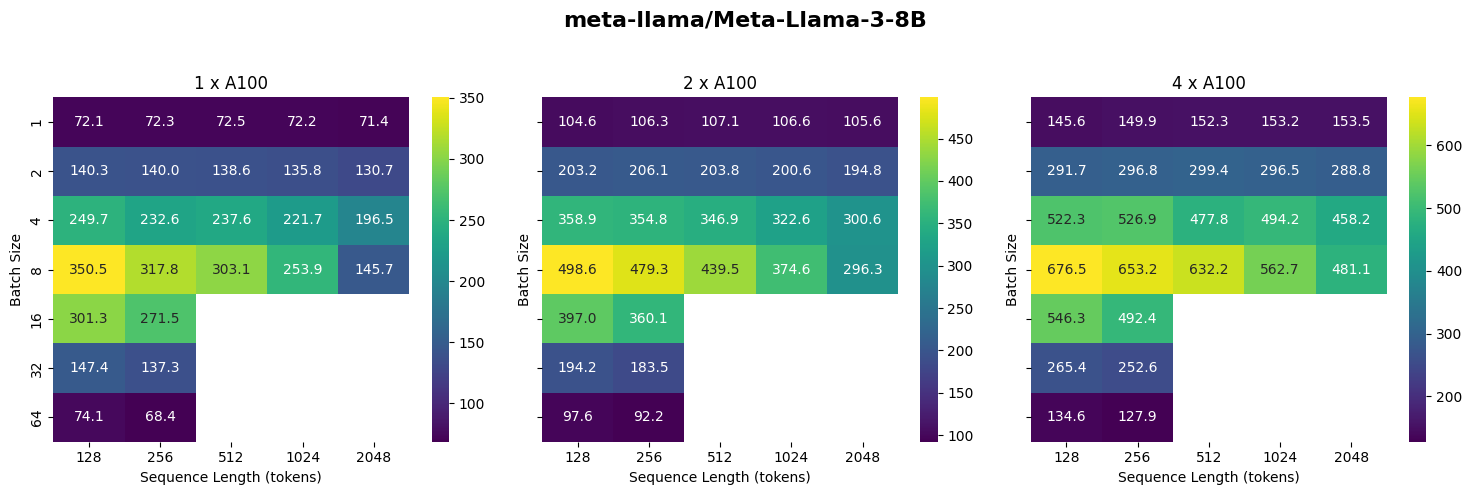

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

n_values = model_df['Count'].unique()
num_plots = len(n_values)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure axes is iterable if only one plot

for ax, n in zip(axes, n_values):
    sub_df = model_df[(model_df['Count'] == n)]

    pivot_table = sub_df.pivot(index='Batch Size', columns='In tokens', values='Throughput')
    
    sns.heatmap(pivot_table, ax=ax, cmap='viridis', annot=True, fmt=".1f", cbar=True)
    
    ax.set_title(f"{n} x A100")
    ax.set_xlabel('Sequence Length (tokens)')
    ax.set_ylabel('Batch Size')
    
fig.suptitle(model, fontsize=16, fontweight='bold') 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Energy

#### Idle and active Power vs batch-size

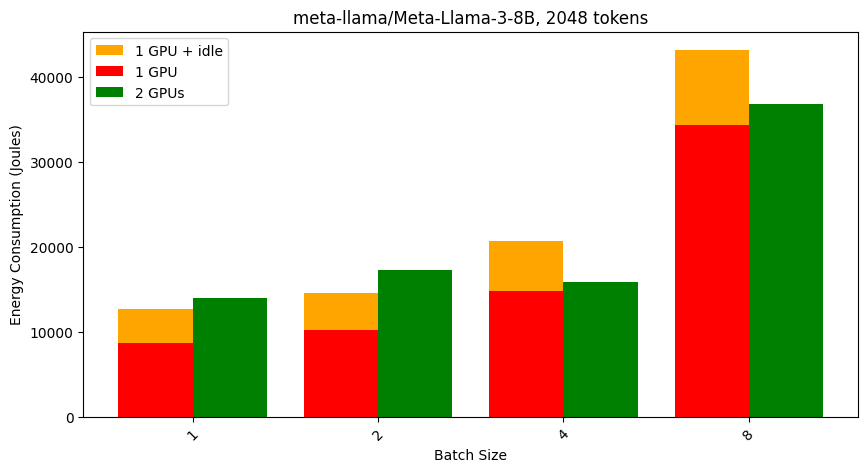

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model = 'meta-llama/Meta-Llama-3-8B'
tokens = 2048

if tokens is None:
    model_df = df[df['Model Name'] == model]
else:
    model_df = df[(df['Model Name'] == model) & (df['In tokens'] == tokens)]

# Get unique batch sizes
batch_sizes = sorted(model_df['Batch Size'].unique())

# Extract energy values for 1 and 2 GPUs
energy_1gpu = []
energy_2gpu = []
active_energy_1gpu = []

for batch in batch_sizes:
    energy_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['Energy'].mean())
    active_energy_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['Energy (Active)'].mean())
    energy_2gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['Energy'].mean())

# Bar width
width = 0.4  
x = np.arange(len(batch_sizes))

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, energy_1gpu, width, label="1 GPU + idle", color = 'orange')
plt.bar(x - width/2, active_energy_1gpu, width, label="1 GPU", color = 'red')
plt.bar(x + width/2, energy_2gpu, width, label="2 GPUs", color = 'green')

plt.xlabel('Batch Size')
plt.ylabel('Energy Consumption (Joules)')
if tokens is None:
    plt.title(f"{model}")
else:
    plt.title(f"{model}, {tokens} tokens")
plt.xticks(x, batch_sizes, rotation=45)
plt.legend()
plt.show()


#### Idle and active power heatmap

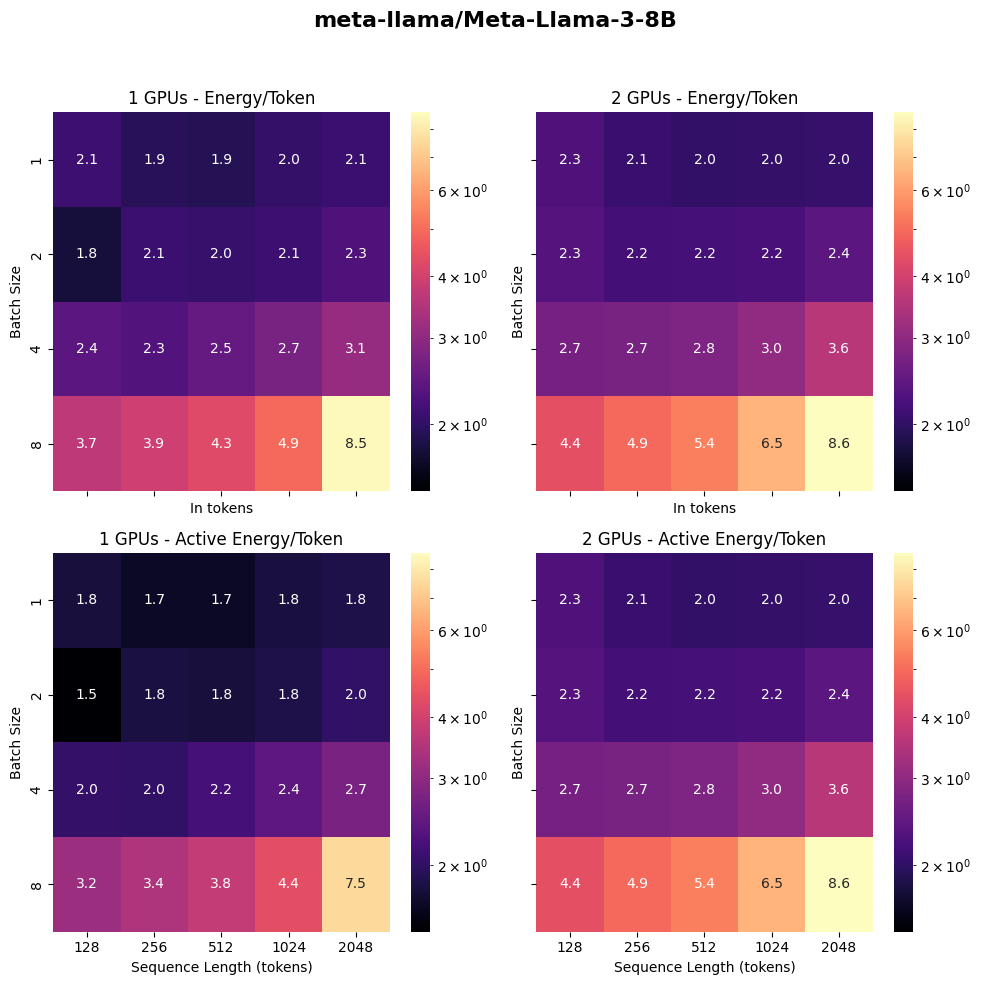

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

model = 'meta-llama/Meta-Llama-3-8B'
model_df = df[(df['Model Name'] == model) & (df['Precision'] == 'float16')]

n_values = sorted(model_df['Count'].unique())  # Sorted GPU counts
num_plots = len(n_values)  # Number of GPU counts

fig, axes = plt.subplots(2, num_plots, figsize=(5 * num_plots, 10), sharex=True, sharey=True)

if num_plots == 1:
    axes = np.array([[axes[0]], [axes[1]]])  # Ensure correct indexing if only one GPU count

# Find global min/max for a unified scale
energy_min = model_df[['Energy/Token', 'Active Energy/Token']].min().min()
energy_max = model_df[['Energy/Token', 'Active Energy/Token']].max().max()

for col, n in enumerate(n_values):
    sub_df = model_df[model_df['Count'] == n]

    # Pivot tables for heatmaps
    energy_pivot = sub_df.pivot(index='Batch Size', columns='In tokens', values='Energy/Token')
    active_energy_pivot = sub_df.pivot(index='Batch Size', columns='In tokens', values='Active Energy/Token')

    # Log scale normalization
    norm = LogNorm(vmin=energy_min, vmax=energy_max)

    # Plot total energy heatmap
    sns.heatmap(energy_pivot, ax=axes[0, col], cmap='magma', annot=True, fmt=".1f", norm=norm, cbar=True)
    axes[0, col].set_title(f"{n} GPUs - Energy/Token")

    # Plot active energy heatmap
    sns.heatmap(active_energy_pivot, ax=axes[1, col], cmap='magma', annot=True, fmt=".1f", norm=norm, cbar=True)
    axes[1, col].set_title(f"{n} GPUs - Active Energy/Token")

    # Labels (only for leftmost column)
    if col == 0:
        axes[0, col].set_ylabel('Batch Size')
        axes[1, col].set_ylabel('Batch Size')

# Common x-labels
for ax in axes[-1, :]:  
    ax.set_xlabel('Sequence Length (tokens)')

# Big title
fig.suptitle(model, fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()


# Polaris

In [ ]:
df['Hardware type'].unique()

array(['NVIDIA A100-PCIE-40GB', 'NVIDIA A100-SXM4-40GB'], dtype=object)

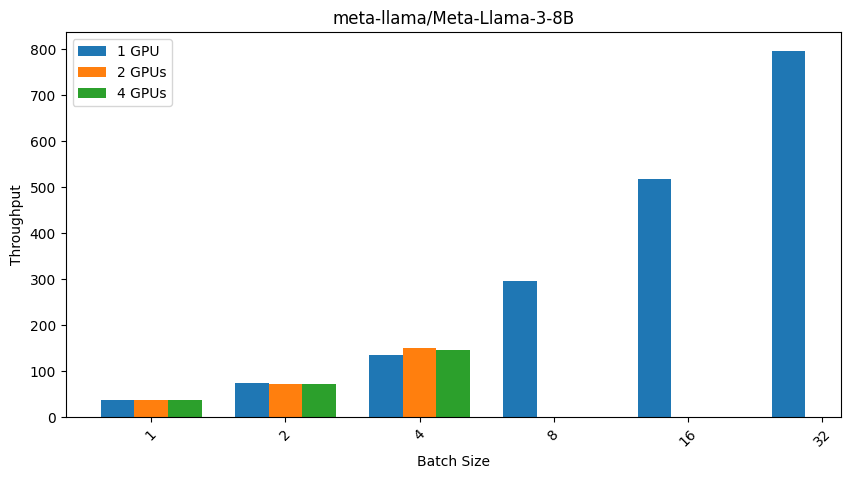

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over each unique model
model = "meta-llama/Meta-Llama-3-8B"
model_df = df[(df['Model Name'] == model) &
              (df['Hardware type'] == 'NVIDIA A100-SXM4-40GB') &
              (df['FrameWork'] == 'Accelerate')]

# Get unique batch sizes
batch_sizes = sorted(model_df['Batch Size'].unique())

# Extract throughput values for 1, 2, and 4 GPUs
throughput_1gpu = []
throughput_2gpu = []
throughput_4gpu = []

for batch in batch_sizes:
    throughput_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['Throughput'].mean())
    throughput_2gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['Throughput'].mean())
    throughput_4gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 4)]['Throughput'].mean())

# Bar width
width = 0.25  
x = np.arange(len(batch_sizes))

plt.figure(figsize=(10, 5))
plt.bar(x - width, throughput_1gpu, width, label="1 GPU")
plt.bar(x, throughput_2gpu, width, label="2 GPUs")  # Fixed x position
plt.bar(x + width, throughput_4gpu, width, label="4 GPUs")  # Fixed x position

plt.xlabel('Batch Size')
plt.ylabel('Throughput')
plt.title(f"{model}")
plt.xticks(x, batch_sizes, rotation=45)
plt.legend()
plt.show()

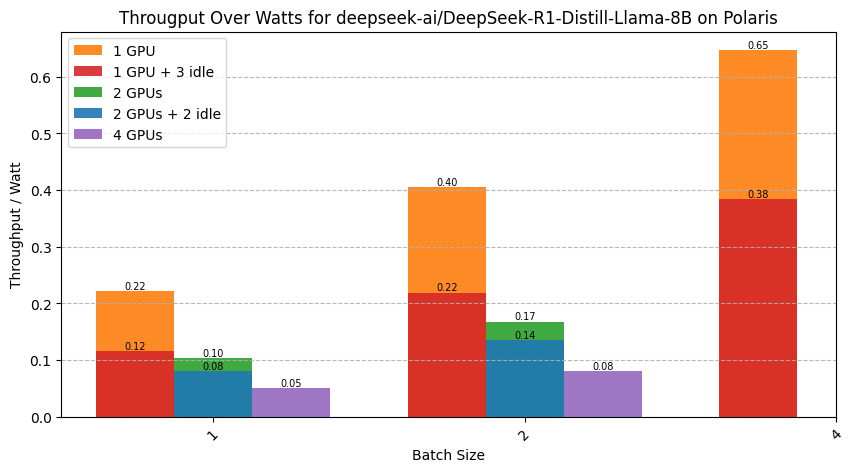

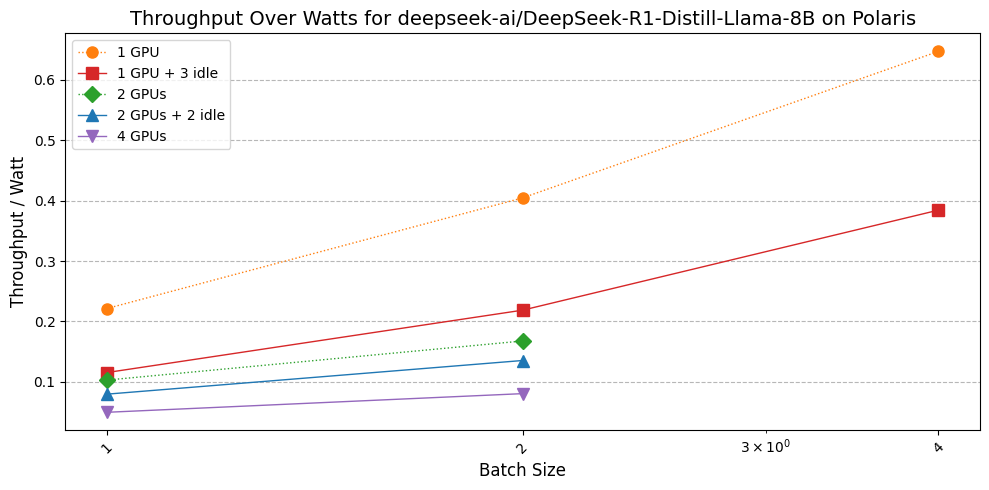

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over each unique model
model = 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'
model_df = df[(df['Model Name'] == model) &
              (df['Out tokens'] == 512) &
              (df['Hardware type'] == 'NVIDIA A100-SXM4-40GB') &
              (df['FrameWork'] == 'Accelerate')]

# Get unique batch sizes
batch_sizes = sorted(model_df['Batch Size'].unique())

# Extract throughput values for 1, 2, and 4 GPUs
throughput_1gpu = []
throughput_2gpu = []
throughput_4gpu = []

throughput_1of4gpu = []
throughput_2of4gpu = []

for batch in batch_sizes:
    throughput_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['TP per Watt (Active)'].mean())
    throughput_2gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['TP per Watt (Active)'].mean())
    throughput_4gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 4)]['TP per Watt (Active)'].mean())
    throughput_1of4gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['TP per Watt'].mean())
    throughput_2of4gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['TP per Watt'].mean())

# Bar width
width = 0.25  
x = np.arange(len(batch_sizes))

colors = ['#ff7f0e', '#d62728', '#2ca02c', '#1f77b4', '#9467bd']
labels = ["1 GPU", "1 GPU + 3 idle", "2 GPUs", "2 GPUs + 2 idle", "4 GPUs"]
data = [throughput_1gpu, throughput_1of4gpu, throughput_2gpu, throughput_2of4gpu, throughput_4gpu]
offsets = [-width, -width, 0, 0, width]

plt.figure(figsize=(10, 5))

for i, (label, color, values, offset) in enumerate(zip(labels, colors, data, offsets)):
    bars = plt.bar(x + offset, values, width, label=label, color=color, alpha=0.9)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=7)


plt.xticks(x, batch_sizes, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.xlabel('Batch Size')
plt.ylabel('Throughput / Watt')
plt.title(f"Througput Over Watts for {model} on Polaris")
plt.xticks(x, batch_sizes, rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

markers = ['o', 's', 'D', '^', 'v']
linestyles = [':', '-', ':', '-', '-']

for i, (label, color, values, line) in enumerate(zip(labels, colors, data, linestyles)):
    plt.semilogx(batch_sizes, values, linestyle=line, marker=markers[i], markersize=8, 
                 color=color, label=label, linewidth=1)

# Formatting
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Throughput / Watt', fontsize=12)
plt.title(f"Throughput Over Watts for {model} on Polaris", fontsize=14)

# Ensuring enough x-axis values
plt.xticks(batch_sizes, batch_sizes, rotation=45, fontsize=10)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


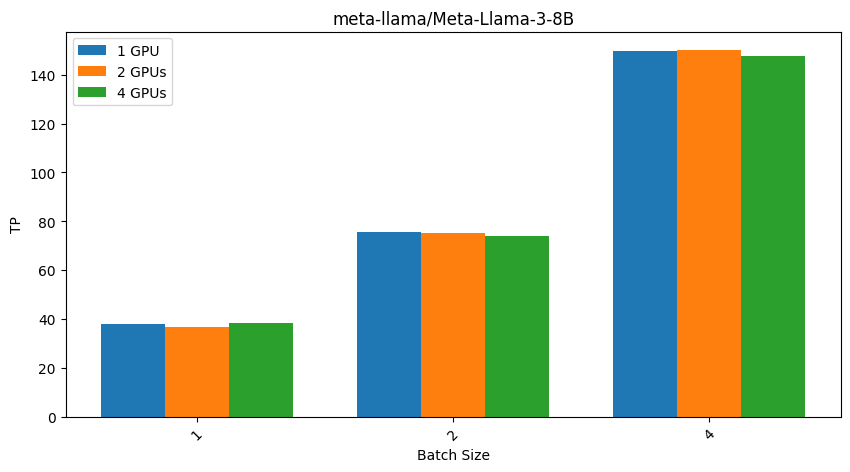

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over each unique model
model = "meta-llama/Meta-Llama-3-8B"
model_df = df[(df['Model Name'] == model) &
              (df['Out tokens'] == 512) &
              (df['Hardware type'] == 'NVIDIA A100-SXM4-40GB') &
              (df['FrameWork'] == 'Accelerate')]

# Get unique batch sizes
batch_sizes = sorted(model_df['Batch Size'].unique())

# Extract throughput values for 1, 2, and 4 GPUs
throughput_1gpu = []
throughput_2gpu = []
throughput_4gpu = []

for batch in batch_sizes:
    throughput_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['Throughput'].mean())
    throughput_2gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['Throughput'].mean())
    throughput_4gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 4)]['Throughput'].mean())

# Bar width
width = 0.25  
x = np.arange(len(batch_sizes))

plt.figure(figsize=(10, 5))
plt.bar(x - width, throughput_1gpu, width, label="1 GPU")
plt.bar(x, throughput_2gpu, width, label="2 GPUs")  # Fixed x position
plt.bar(x + width, throughput_4gpu, width, label="4 GPUs")  # Fixed x position

plt.xlabel('Batch Size')
plt.ylabel('TP')
plt.title(f"{model}")
plt.xticks(x, batch_sizes, rotation=45)
plt.legend()
plt.show()

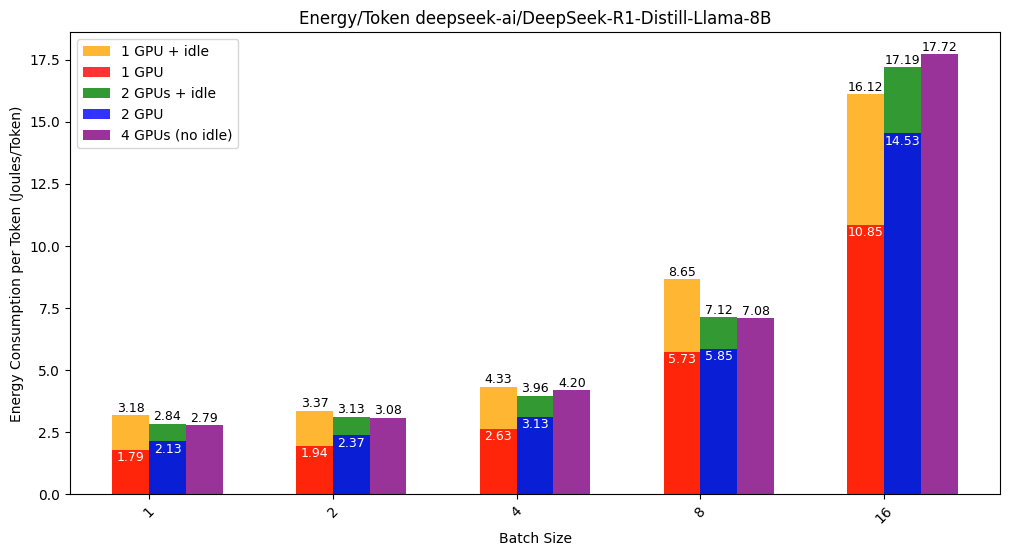

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model = 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'
model_df = df[(df['Model Name'] == model) &
              (df['Hardware type'] == 'NVIDIA A100-SXM4-40GB') &
              (df['FrameWork'] == 'vLLM') &
              ((df['Batch Size'] < 32))]
# Get unique batch sizes
batch_sizes = sorted(model_df['Batch Size'].unique())

# Extract energy values for 1, 2, and 4 GPUs
energy_1gpu = []
active_energy_1gpu = []
energy_2gpu = []
active_energy_2gpu = []
energy_4gpu = []

for batch in batch_sizes:
    energy_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['Energy/Token'].mean())
    active_energy_1gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 1)]['Active Energy/Token'].mean())
    energy_2gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['Energy/Token'].mean())
    active_energy_2gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 2)]['Active Energy/Token'].mean())
    energy_4gpu.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Count'] == 4)]['Energy/Token'].mean())

# Bar width
width = 0.2  
x = np.arange(len(batch_sizes))

plt.figure(figsize=(12, 6))

# Plot overlapping bars
plt.bar(x - 0.5 * width, energy_1gpu, width, label="1 GPU + idle", color='orange', alpha=0.8)
plt.bar(x - 0.5 * width, active_energy_1gpu, width, label="1 GPU", color='red', alpha=0.8)
plt.bar(x + 0.5 * width, energy_2gpu, width, label="2 GPUs + idle", color='green', alpha=0.8)
plt.bar(x + 0.5 * width, active_energy_2gpu, width, label="2 GPU", color='blue', alpha=0.8)
plt.bar(x + 1.5 * width, energy_4gpu, width, label="4 GPUs (no idle)", color='purple', alpha=0.8)

# Add labels on bars
for i, batch in enumerate(batch_sizes):
    plt.text(x[i] - 0.5 * width, energy_1gpu[i] + 0.02, f'{energy_1gpu[i]:.2f}', ha='center', va='bottom', fontsize=9, color='black')
    plt.text(x[i] - 0.5 * width, active_energy_1gpu[i] - 0.05, f'{active_energy_1gpu[i]:.2f}', ha='center', va='top', fontsize=9, color='white')
    plt.text(x[i] + 0.5 * width, energy_2gpu[i] + 0.02, f'{energy_2gpu[i]:.2f}', ha='center', va='bottom', fontsize=9, color='black')
    plt.text(x[i] + 0.5 * width, active_energy_2gpu[i] - 0.05, f'{active_energy_2gpu[i]:.2f}', ha='center', va='top', fontsize=9, color='white')
    plt.text(x[i] + 1.5 * width, energy_4gpu[i] + 0.02, f'{energy_4gpu[i]:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('Batch Size')
plt.ylabel('Energy Consumption per Token (Joules/Token)')
plt.title(f"Energy/Token {model}")
plt.xticks(x, batch_sizes, rotation=45)
plt.legend()
plt.show()


# Stellar

In [ ]:
model_df[(model_df['Batch Size'] == batch) & (model_df['Hardware type'] == 'Intel(R) Data Center GPU Max 1550')]['Throughput'].mean()

nan

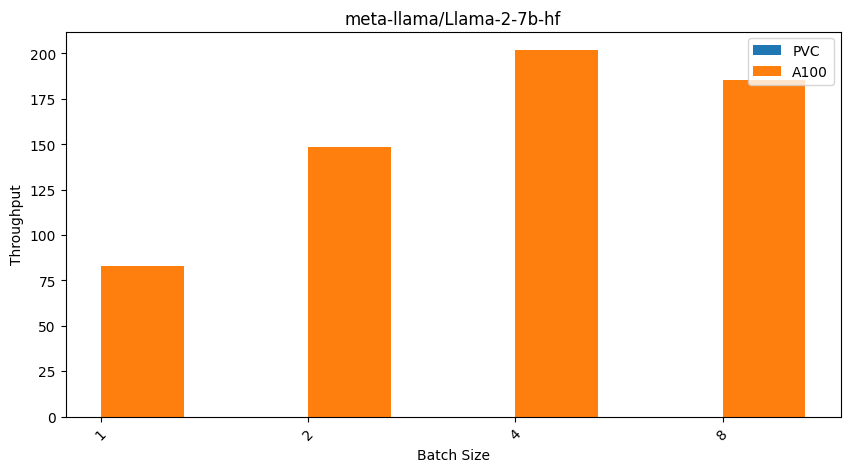

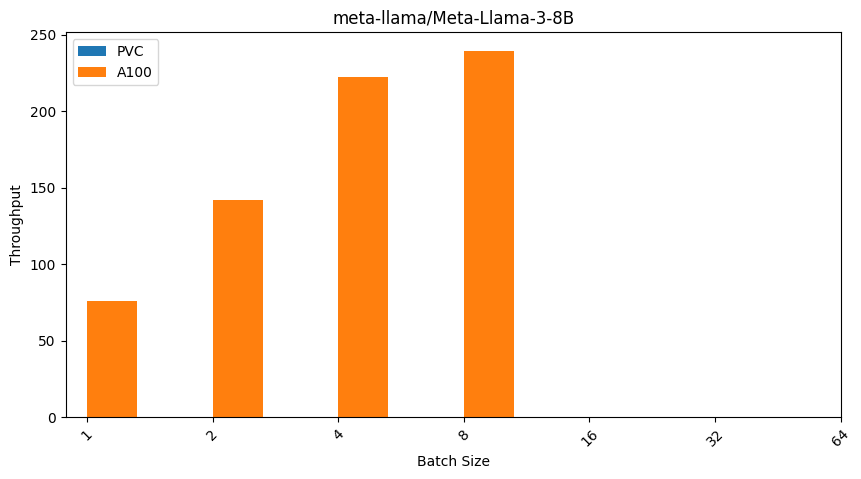

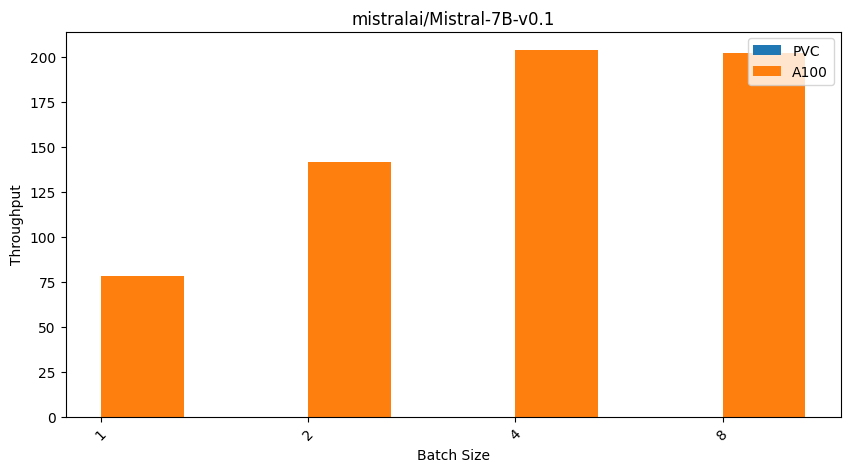

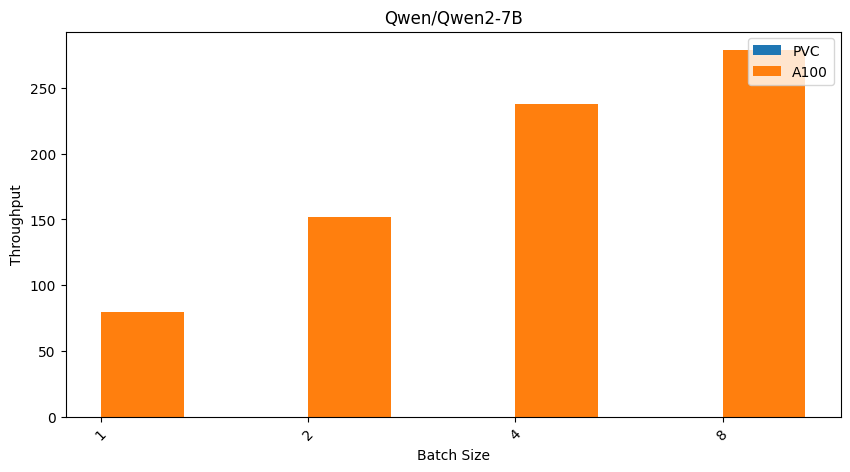

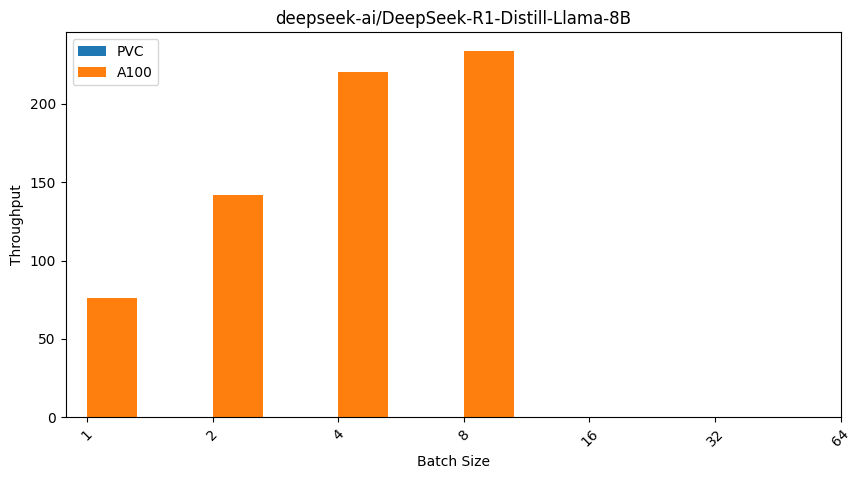

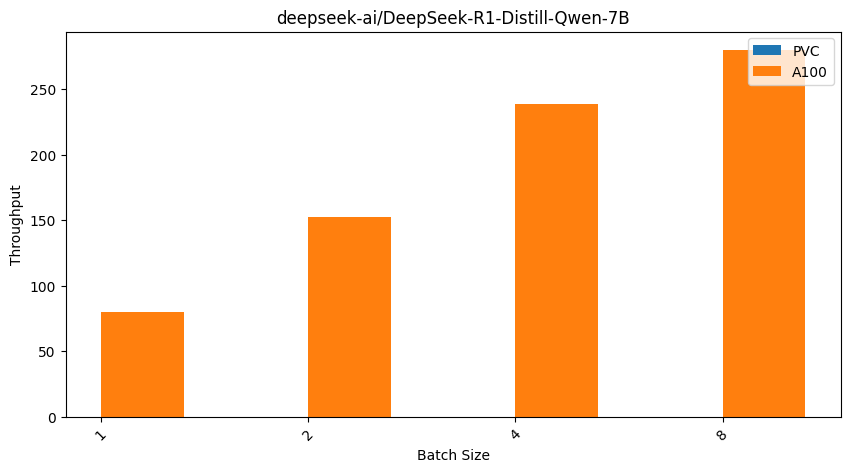

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over each unique model
for model in df['Model Name'].unique():
    model_df = df[(df['Model Name'] == model)]
    # Get unique batch sizes
    batch_sizes = sorted(model_df['Batch Size'].unique())

    # Extract throughput values for 1 and 2 GPUs
    throughput_PVC = []
    throughput_A100 = []

    for batch in batch_sizes:
        throughput_A100.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Hardware type'] == 'NVIDIA A100-PCIE-40GB')]['Throughput'].mean())
        throughput_PVC.append(model_df[(model_df['Batch Size'] == batch) & (model_df['Hardware type'] == 'Intel(R) Data Center GPU Max 1550')]['Throughput'].mean())

    # Bar width
    width = 0.4  
    x = np.arange(len(batch_sizes))

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, throughput_PVC, width, label="PVC")
    plt.bar(x + width/2, throughput_A100, width, label="A100")

    plt.xlabel('Batch Size')
    plt.ylabel('Throughput')
    plt.title(f"{model}")
    plt.xticks(x, batch_sizes, rotation=45)
    plt.legend()
    plt.show()
